# Genetic influences on brain representations of natural audiovisual experiences

This notbook written by Satoshi Nishida includes the code underlying all figures and tables in our research paper.

## Requirements:

* FreeSurfer (https://surfer.nmr.mgh.harvard.edu/)
* ImageMagick (https://imagemagick.org/)
* The following Python libralies
 * nibabel (https://nipy.org/nibabel/)
 * mayavi (https://mayavi.readthedocs.io/)
 * pysurfer (https://pysurfer.github.io/)

In [1]:
import os
import os.path
import sys

import subprocess
import platform

import numpy as np
import pandas as pd
import h5py
import scipy.io
from scipy import stats
from scipy.spatial import distance

from mayavi import mlab
import nibabel as nib
from surfer import Brain

from statsmodels.stats.multitest import fdrcorrection

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import mpl_toolkits.axes_grid1
from mpl_toolkits.mplot3d import Axes3D

## General settings

In [2]:
data_file = "data.h5"
out_dir = "out"

subctx_ids = [4, 0, 8, 1, 9, 2, 10, 3, 11, 5, 12, 6, 13, 7, 14]
n_subctxs = len(subctx_ids)

roi_type = "Destrieux"
annot_suffix = "aparc.a2009s.annot"
lh_prefix = "ctx_lh_"
rh_prefix = "ctx_rh_"

## Preparation for matplotlib

In [3]:
mpl.use("Agg")
%matplotlib inline

params = {
    "figure.figsize": [6, 6],
    "figure.autolayout": False,
    "font.weight": "normal",
    "font.family": "Arial", # ~/.cache/matplotlib/fontList.json shows available fonts
    "font.size": 18,
    "legend.fontsize": 18,
    "lines.linewidth": .5,
    "axes.linewidth": .5,
    "xtick.major.width": .5,
    "ytick.major.width": .5,
    "pdf.fonttype": 42, # Avoid Type3 fonts
}
mpl.rcParams.update(params)

## Preparation for pysurfer

In [4]:
mlab.options.offscreen = True

pf = platform.system()
if pf == "Darwin":
    subjects_dir = "/Applications/freesurfer/subjects"
elif pf == "Linux":
    subjects_dir = "/usr/local/freesurfer/subjects"
    
subject_id = "fsaverage"
surf = "inflated"

lh_aparc_file = os.path.join(subjects_dir, subject_id, "label", "lh." + annot_suffix)
rh_aparc_file = os.path.join(subjects_dir, subject_id, "label", "rh." + annot_suffix)

# Load ROI labels and names
lh_labels, _, lh_names = nib.freesurfer.read_annot(lh_aparc_file)
rh_labels, _, rh_names = nib.freesurfer.read_annot(rh_aparc_file)

n_hemi_rois = len(lh_names)

### Function for original colormap generation

In [5]:
def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v / vmax, c) )
    return LinearSegmentedColormap.from_list("custom_cmap", color_list)

## Load data

In [6]:
with h5py.File(data_file, "r") as f:
    for key in f.keys():
        exec(f"{key} = f['{key}'][()]")

roi_names = np.array([x.decode("utf8") for x in roi_names])

## Make the output directory

In [7]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Fig. 2: Correlation of CRD between repetitions

### Generate a table

In [8]:
out_file = os.path.join(out_dir, "reprod_corr.csv")

# Get P values corrected using FDR
stat = np.array([stats.wilcoxon(x)[:] for x in clip_dist_corr])
T_vals = stat[:, 0]
p_vals = stat[:, 1]
rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)

# Average over subjects
roi_mean_corr = clip_dist_corr.mean(axis=1)

# Save the table to a excel file
cols = ["Region name", "Mean correlation coefficient", "T static", "P value (FDR corrected)"]

d = np.zeros((n_rois, 3))
d[:, 0] = roi_mean_corr
d[:, 1] = T_vals
d[:, 2] = corr_p_vals

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping

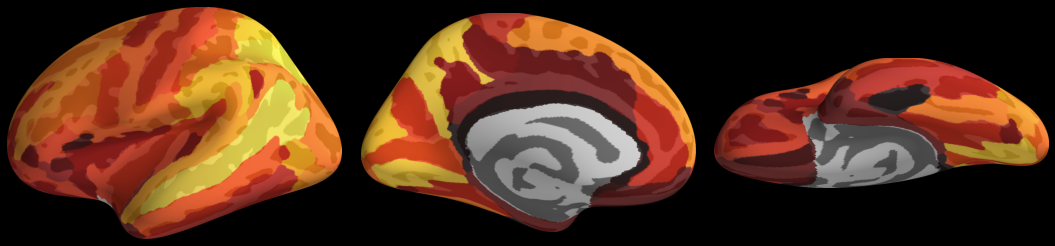

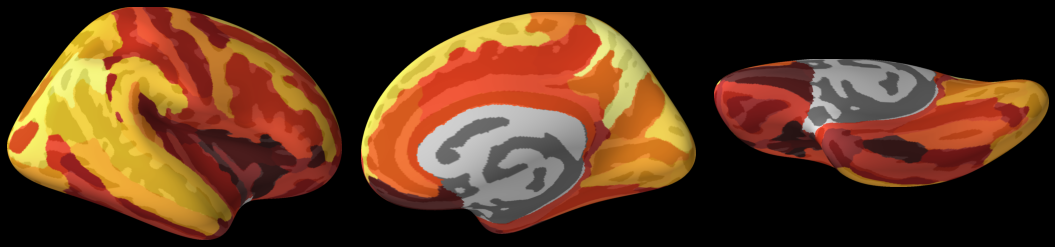

In [9]:
out_base = os.path.join(out_dir, "reprod_corr")

vals = roi_mean_corr
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, rejected[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

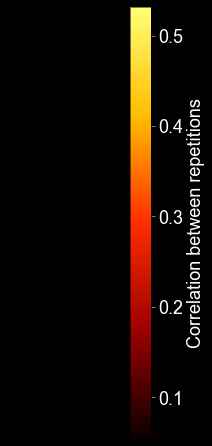

In [10]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Correlation between repetitions", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Subcortex

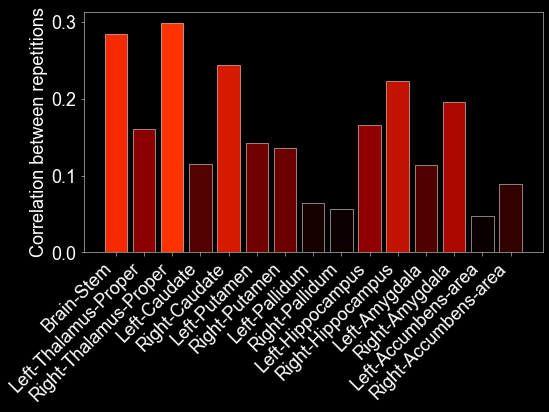

In [11]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = roi_mean_corr[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Correlation between repetitions", color="w")
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "reprod_corr_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Fig. 3: Representational variability across brain regions

### 3D plot

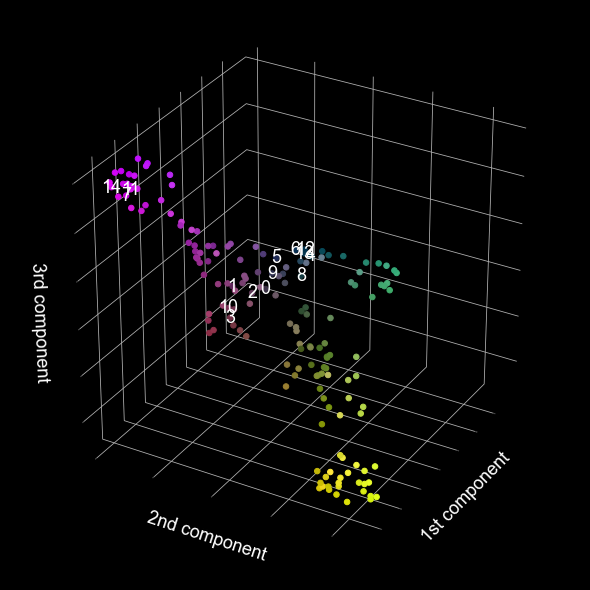

In [12]:
cols = np.ones((n_rois, 4))
for i in range(3):
    cols[:, i] = (umap_u[:, i] - umap_u[:, i].min()) / (umap_u[:, i].max() - umap_u[:, i].min())
    
# Plot
fig = plt.figure(figsize=(8, 8), facecolor="k")
ax = Axes3D(fig)

ax.scatter(umap_u[:, 0], umap_u[:, 1], zs=umap_u[:, 2], zdir="z", s=30, c=cols, alpha=1)

# Subcottex
for i in range(n_subctxs):
    ax.text(umap_u[i, 0], umap_u[i, 1], umap_u[i, 2], str(i), c="w", ha="center", va="center")

ax.view_init(elev=30, azim=30)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(length=0)

ax.set_xlabel("1st component", c="w")
ax.set_ylabel("2nd component", c="w")
ax.set_zlabel("3rd component", c="w")

ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1] * 0.95])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 0.95])
ax.set_zlim([ax.get_zlim()[0], ax.get_zlim()[1] * 0.97])

ax.set_facecolor("k")
ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))
plt.rcParams["grid.color"] = (.3, .3, .3)

plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "umap_3d.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Cortical map

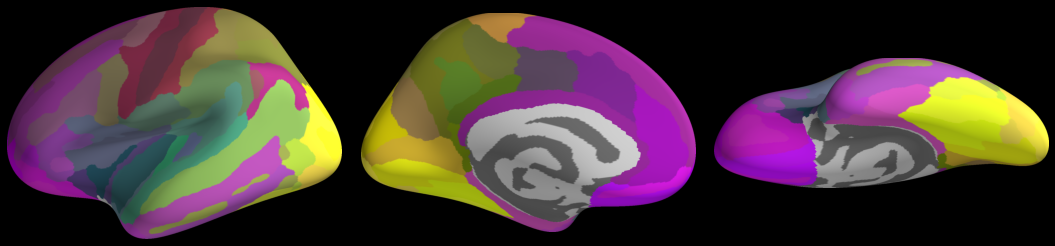

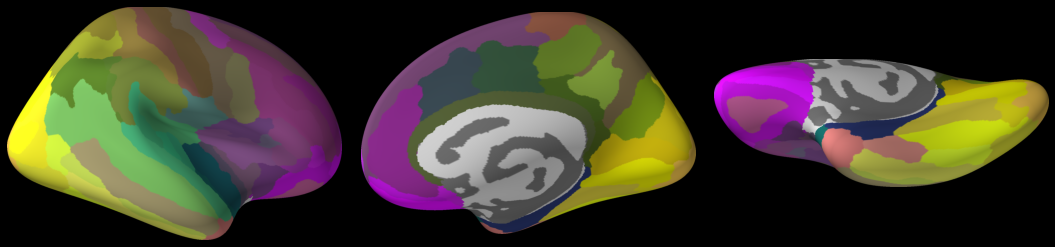

In [13]:
out_base = os.path.join(out_dir, "umap")

vals = np.arange(n_rois)
null_val = -1

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = roi_idx[i, :] != -1
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = 0
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(cols)    
    
views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

## Supplementary Fig. 1: Visualization of representational variability using other dimension reduction methods (Isomap)

### 3D plot

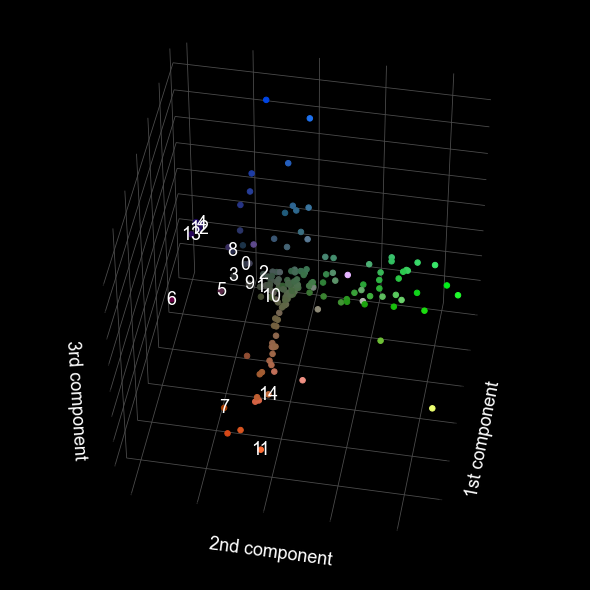

In [14]:
cols = np.ones((n_rois, 4))
for i in range(3):
    cols[:, i] = (isomap_scores[:, i] - isomap_scores[:, i].min()) / (isomap_scores[:, i].max() - isomap_scores[:, i].min())
    
# Plot
fig = plt.figure(figsize=(8, 8), facecolor="k")
ax = Axes3D(fig)

ax.scatter(isomap_scores[:, 0], isomap_scores[:, 1], zs=isomap_scores[:, 2], zdir="z", s=30, c=cols, alpha=1)

# Subcottex
for i in range(n_subctxs):
    ax.text(isomap_scores[i, 0], isomap_scores[i, 1], isomap_scores[i, 2], str(i), c="w", ha="center", va="center")

ax.view_init(elev=45, azim=10)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.tick_params(length=0)

ax.set_xlabel("1st component", c="w")
ax.set_ylabel("2nd component", c="w")
ax.set_zlabel("3rd component", c="w")

ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1] * 0.95])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 0.95])
ax.set_zlim([ax.get_zlim()[0], ax.get_zlim()[1] * 0.97])

ax.set_facecolor("k")
ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))
plt.rcParams["grid.color"] = (.3, .3, .3)

plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "isomap_3d.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Cortical map

colormap sequential: [0.00e+00, 8.10e+01, 1.62e+02] (opaque)


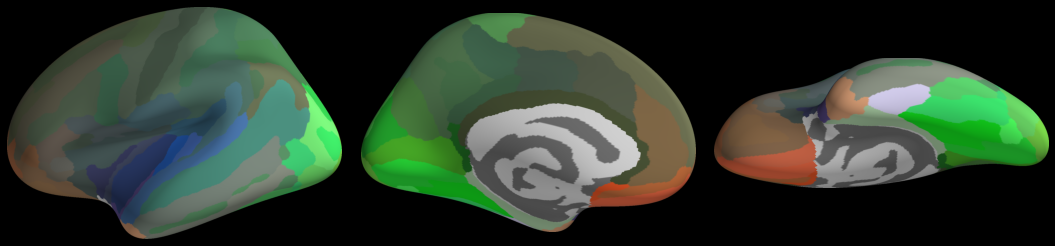

colormap sequential: [0.00e+00, 8.10e+01, 1.62e+02] (opaque)


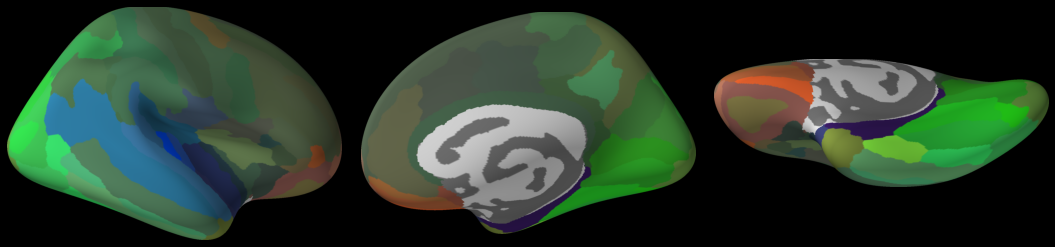

In [15]:
out_base = os.path.join(out_dir, "isomap")

vals = np.arange(n_rois)
null_val = -1

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = roi_idx[i, :] != -1
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = 0
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(cols)    
    
views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm,
                   colorbar=False, smoothing_steps=None)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

## Fig. 4: Cortical mapping of Noise ceiling

### Generate a table

In [16]:
out_file = os.path.join(out_dir, "noise_ceiling.csv")

# Get P values corrected using FDR
stat = np.array([stats.wilcoxon(x)[:] for x in clip_dist_corr])
T_vals = stat[:, 0]
p_vals = stat[:, 1]
rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)

# Average over subjects
mean_noise_ceiling = noise_ceiling.mean(axis=1)

# Save the table to a excel file
cols = ["Region name", "Noise ceiling"]

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], mean_noise_ceiling[:, np.newaxis]]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping

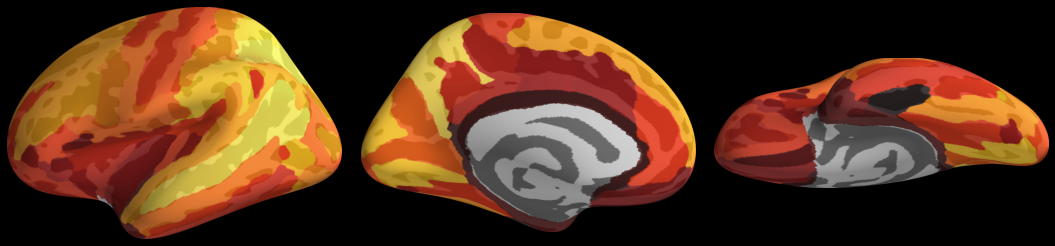

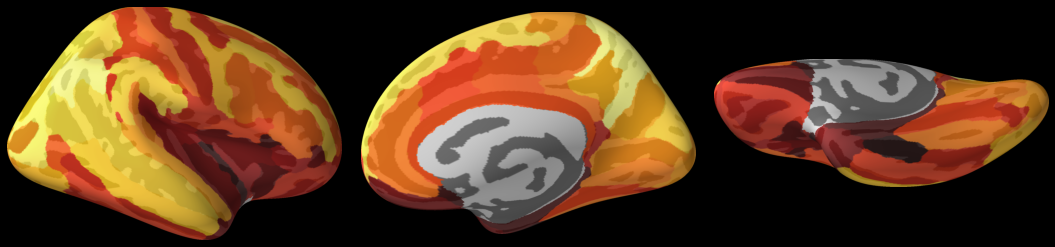

In [17]:
out_base = os.path.join(out_dir, "noise_ceiling")

vals = mean_noise_ceiling
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, rejected[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

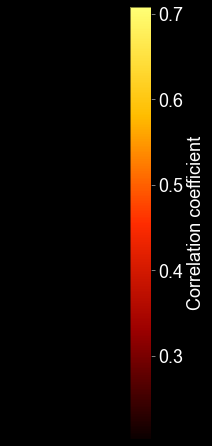

In [18]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Correlation coefficient", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Correlation between noise ceiling and reproducibility

In [19]:
r, p = stats.pearsonr(clip_dist_corr.mean(axis=1), noise_ceiling.mean(axis=1))
print("r = {}, p = {}".format(r, p))

r = 0.9421390624076028, p = 2.523464400794885e-78


### Subcortex

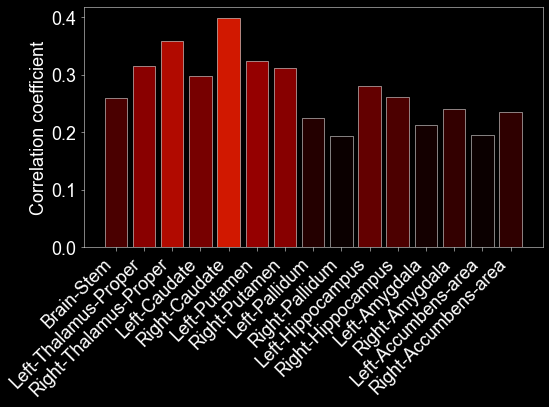

In [20]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = mean_noise_ceiling[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Correlation coefficient", color="w")
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "noise_ceiling_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Fig. 5: Representational similarity for MZ and DZ pairs after noise-ceiling correction

### Generate tables

In [21]:
out_file = os.path.join(out_dir, "twin_sim.csv")

T_vals = np.zeros((n_rois, 2))
corr_p_vals = np.ones((n_rois, 2))
twin_sim_rejected = np.zeros((n_rois, 2))
roi_mean_sim = np.zeros((n_rois, 2))

for i, zygote in enumerate(["mz", "dz"]):
    # Get P values corrected using FDR
    stat = np.array([stats.wilcoxon(x)[:] for x in eval(zygote + "_sim")])
    T_vals[:, i] = stat[:, 0]
    p_vals = stat[:, 1]
    twin_sim_rejected[:, i], corr_p_vals[:, i] = fdrcorrection(p_vals, alpha=0.05)
    
    roi_mean_sim[:, i] = eval("mean_" + zygote + "_sim")

# Save the table to a excel file
cols = ["Region name", "MZ similarity", "T value", "P value (FDR corrected)", "DZ similarity", "T Value", "P value (FDR corrected)"]

d = np.zeros((n_rois, 6))
d[:, 0] = roi_mean_sim[:, 0]
d[:, 1] = T_vals[:, 0]
d[:, 2] = corr_p_vals[:, 0]
d[:, 3] = roi_mean_sim[:, 1]
d[:, 4] = T_vals[:, 1]
d[:, 5] = corr_p_vals[:, 1]

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping

mz pairs


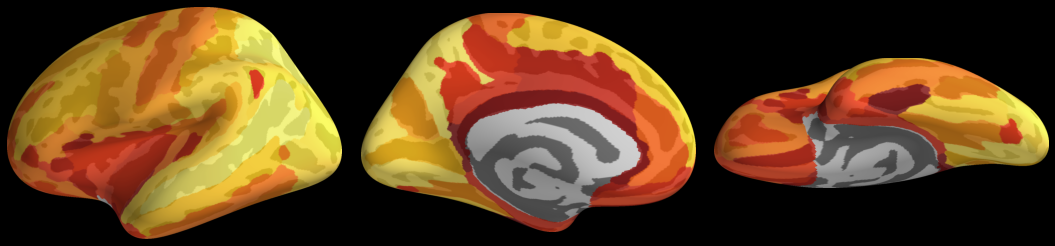

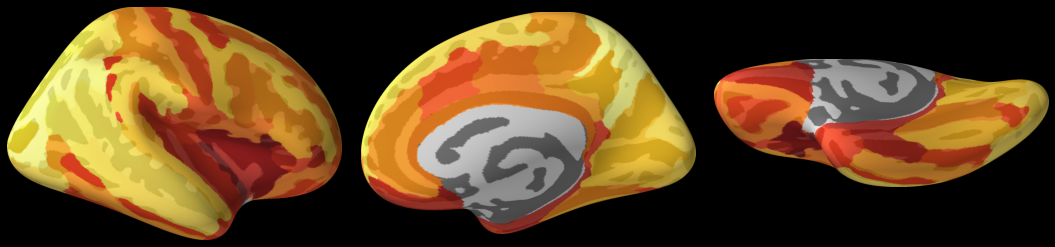

dz pairs


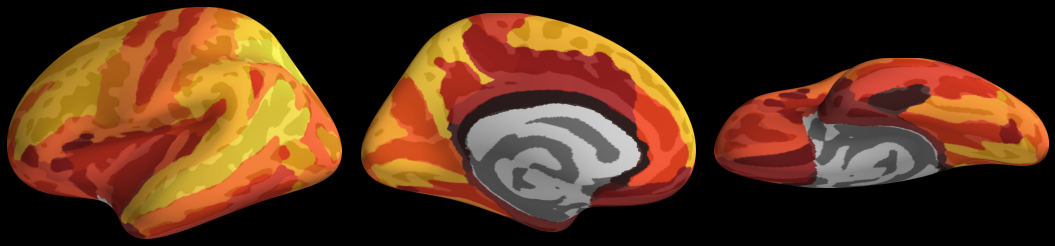

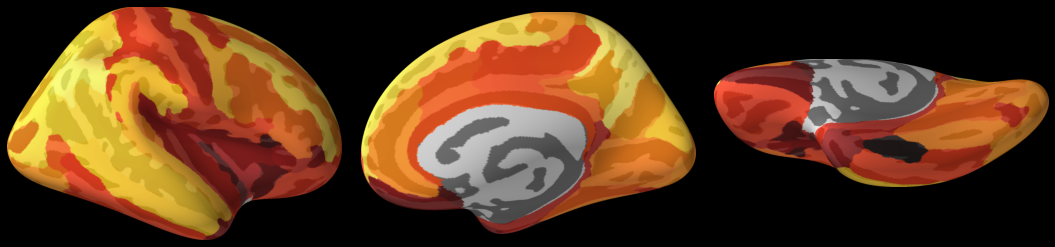

In [22]:
out_base = os.path.join(out_dir, "twin_sim")

vals = roi_mean_sim
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, 2, n_hemi_rois)) + null_val  # zygote x hemisphere x ROI
for zi, _ in enumerate(["mz", "dz"]):
    for i in range(2):
        mask = np.logical_and(roi_idx[i, :] != -1, twin_sim_rejected[roi_idx[i, :], zi])
        hemi_vals[zi, i, mask] = vals[roi_idx[i, mask], zi]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for zi, zygote in enumerate(["mz", "dz"]):
    print(zygote + " pairs")
    
    for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
        # Bring up the visualization.
        brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

        vtx_data = hemi_vals[zi, i, labels]
        vtx_data[labels == -1] = null_val
        brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                       colorbar=False, smoothing_steps=None, verbose=0)

        ## Save views
        for view in views:
            brain.show_view(view)
            fname = "{}_{}_{}_{}.png".format(out_base, zygote, hemi, view)
            brain.save_image(fname)

            ## Trim
            cmd = 'mogrify -trim ' + fname
            subprocess.call(cmd.split())

        ### Show images
        plt.figure(figsize=(15, 5), facecolor="k")

        for vi, view in enumerate(views):
            img = np.array(Image.open("{}_{}_{}_{}.png".format(out_base, zygote, hemi, view)))
            plt.subplot(1, 3, vi + 1)
            plt.imshow(img)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        brain.close()

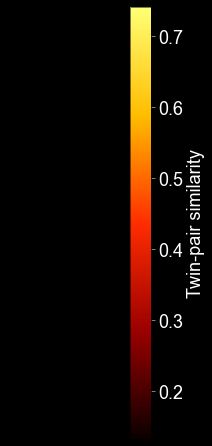

In [23]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Twin-pair similarity", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Subcortex

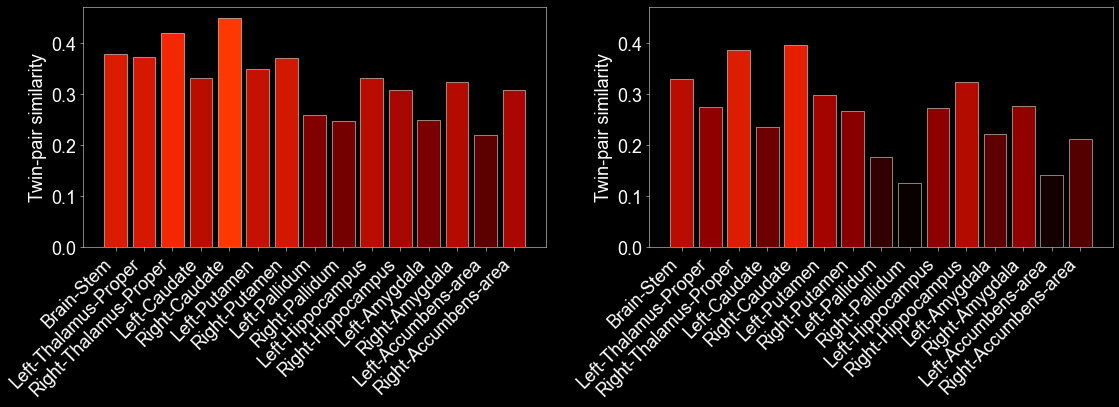

In [24]:
fig = plt.figure(figsize=(16, 6), facecolor="k")

subctx_max = roi_mean_sim[subctx_ids].max()

for zi, _ in enumerate(["mz", "dz"]):
    
    ax = fig.add_subplot(1, 2, zi + 1)

    x = np.arange(n_subctxs)
    y = roi_mean_sim[subctx_ids, zi]
    ps = corr_p_vals[subctx_ids, zi]
    for xx, yy, p in zip(x, y, ps):
        idx = int((yy - min_val) / (max_val - min_val) * 255)
        if idx < 0:
            idx = 0
        c = cm(idx)
        ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)

    ax.set_facecolor("k")
    ax.spines["bottom"].set_color("w")
    ax.spines["top"].set_color("w")
    ax.spines["left"].set_color("w")
    ax.spines["right"].set_color("w")

    ax.set_xticks(x)
    ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
    ax.set_ylabel("Twin-pair similarity", color="w")
    ax.set_ylim((0, subctx_max * 1.05))
    ax.tick_params(colors="w")

    ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "twin_sim_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Correlation between MZ and DZ similarity

In [25]:
r, p = stats.pearsonr(mean_mz_sim, mean_dz_sim)
print("r = {}, p = {}".format(r, p))

r = 0.9443947668362767, p = 1.125474388648242e-79


## Supplementary Fig. 2A–D: Twin-pair similarity without noise-ceiling correction

### Generate tables

In [26]:
out_file = os.path.join(out_dir, "uncor_twin_sim.csv")

roi_mean_sim = np.zeros((n_rois, 2))

for i, zygote in enumerate(["mz", "dz"]):
    roi_mean_sim[:, i] = eval(zygote + "_sim").mean(axis=1)

# Save the table to a excel file
cols = ["Region name", "MZ similarity", "DZ similarity"]

d = np.zeros((n_rois, 2))
d[:, 0] = roi_mean_sim[:, 0]
d[:, 1] = roi_mean_sim[:, 1]

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping

mz pairs


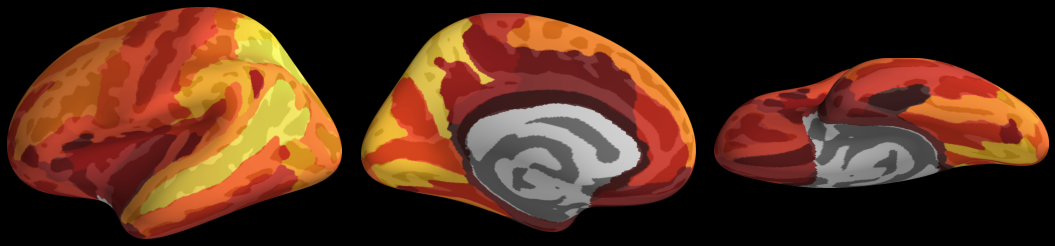

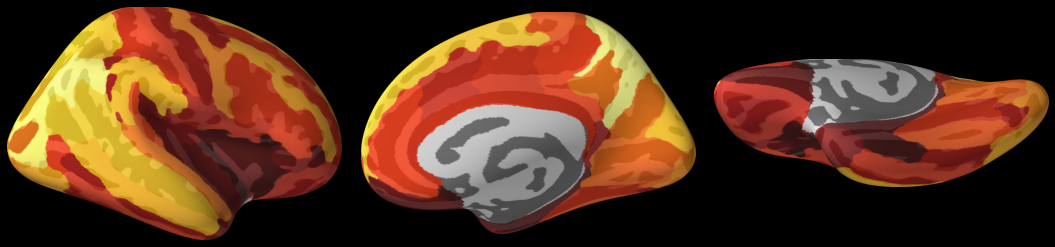

dz pairs


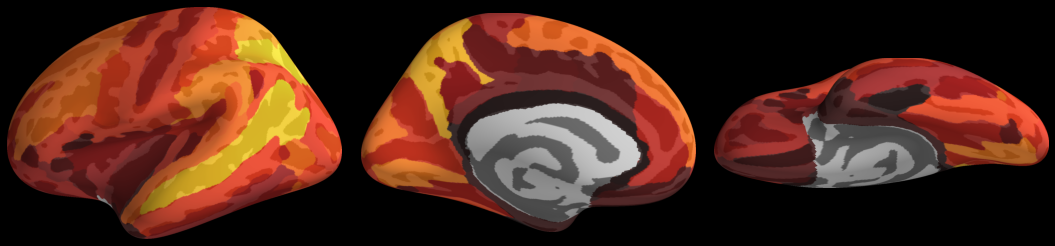

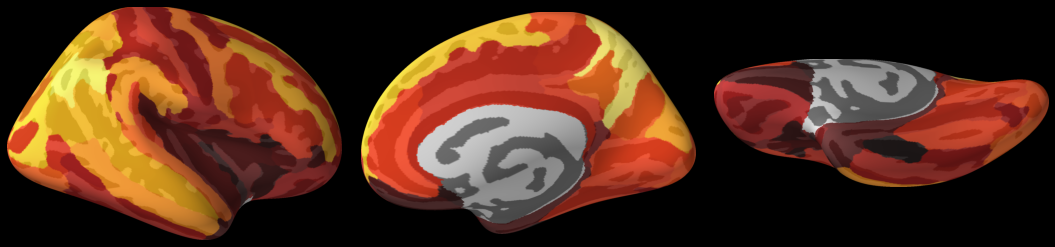

In [27]:
out_base = os.path.join(out_dir, "uncor_twin_sim")

vals = roi_mean_sim
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, 2, n_hemi_rois)) + null_val  # zygote x hemisphere x ROI
for zi, _ in enumerate(["mz", "dz"]):
    for i in range(2):
        mask = np.logical_and(roi_idx[i, :] != -1, twin_sim_rejected[roi_idx[i, :], zi])
        hemi_vals[zi, i, mask] = vals[roi_idx[i, mask], zi]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for zi, zygote in enumerate(["mz", "dz"]):
    print(zygote + " pairs")
    
    for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
        # Bring up the visualization.
        brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

        vtx_data = hemi_vals[zi, i, labels]
        vtx_data[labels == -1] = null_val
        brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                       colorbar=False, smoothing_steps=None, verbose=0)

        ## Save views
        for view in views:
            brain.show_view(view)
            fname = "{}_{}_{}_{}.png".format(out_base, zygote, hemi, view)
            brain.save_image(fname)

            ## Trim
            cmd = 'mogrify -trim ' + fname
            subprocess.call(cmd.split())

        ### Show images
        plt.figure(figsize=(15, 5), facecolor="k")

        for vi, view in enumerate(views):
            img = np.array(Image.open("{}_{}_{}_{}.png".format(out_base, zygote, hemi, view)))
            plt.subplot(1, 3, vi + 1)
            plt.imshow(img)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        brain.close()

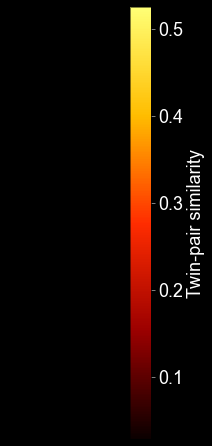

In [28]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Twin-pair similarity", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Subcortex

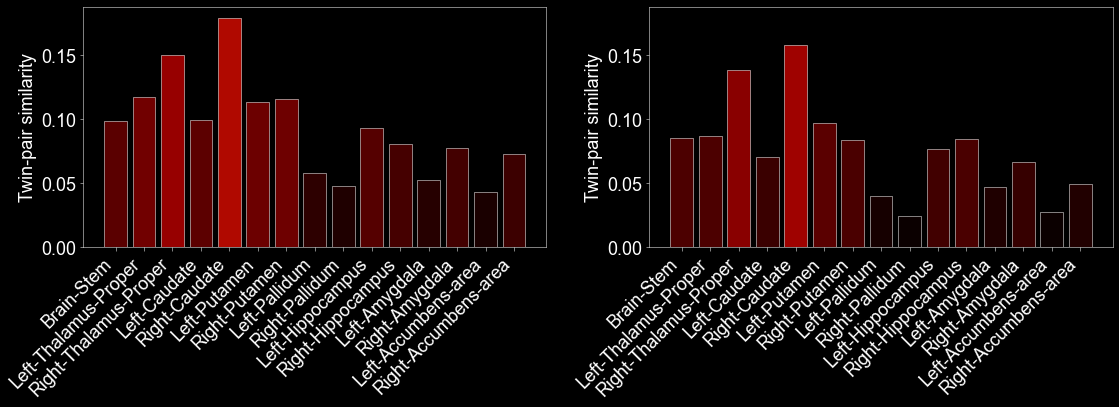

In [29]:
fig = plt.figure(figsize=(16, 6), facecolor="k")

subctx_max = roi_mean_sim[subctx_ids].max()

for zi, _ in enumerate(["mz", "dz"]):
    
    ax = fig.add_subplot(1, 2, zi + 1)

    x = np.arange(n_subctxs)
    y = roi_mean_sim[subctx_ids, zi]
    ps = corr_p_vals[subctx_ids, zi]
    for xx, yy, p in zip(x, y, ps):
        idx = int((yy - min_val) / (max_val - min_val) * 255)
        if idx < 0:
            idx = 0
        c = cm(idx)
        ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)

    ax.set_facecolor("k")
    ax.spines["bottom"].set_color("w")
    ax.spines["top"].set_color("w")
    ax.spines["left"].set_color("w")
    ax.spines["right"].set_color("w")

    ax.set_xticks(x)
    ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
    ax.set_ylabel("Twin-pair similarity", color="w")
    ax.set_ylim((0, subctx_max * 1.05))
    ax.tick_params(colors="w")

    ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "uncor_twin_sim_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Fig. 6 and Supplementary Fig. 3: Heritability after noise-ceiling correction

### Generate tables

In [30]:
out_file = os.path.join(out_dir, "herit.csv")

stat = np.array([stats.wilcoxon(x, y) for x, y in zip(mz_sim, dz_sim)])
T_vals = stat[:, 0]
p_vals = stat[:, 1]
twin_sim_rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)
mask_gen_effect = np.logical_and(twin_sim_rejected, mz_sim.mean(axis=1) > dz_sim.mean(axis=1))

# Save the table to a excel file
cols = ["Region name", "MZ-DZ difference T value", "MZ-DZ difference P value (FDR corrected)", "Falconer's heritability", "Holzinger's heritability"]

d = np.zeros((n_rois, 4))
d[:, 0] = T_vals
d[:, 1] = corr_p_vals
d[:, 2] = herit_falconer
d[:, 3] = herit_holzinger

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping of Falconer's heritability

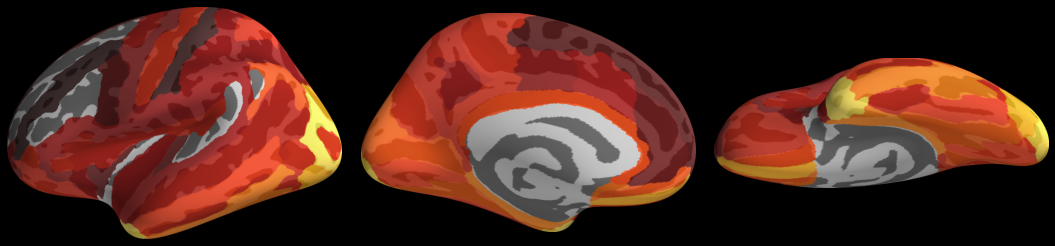

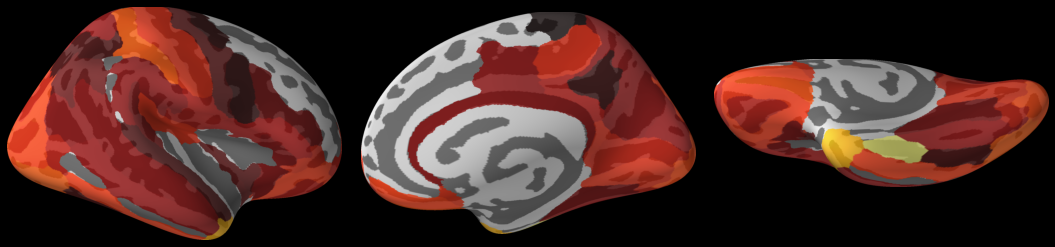

In [31]:
out_base = os.path.join(out_dir, "herit_falconer")

vals = herit_falconer
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

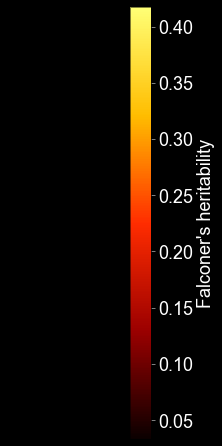

In [32]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Falconer's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Falconer's heritability in subcortex

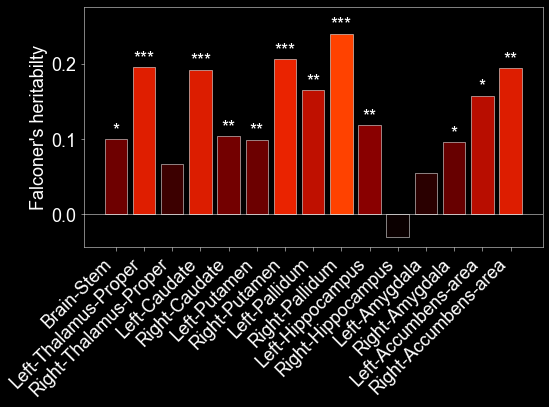

In [33]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = herit_falconer[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.005, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Falconer's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "herit_falconer_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Cortical mapping of Holzinger's heritability

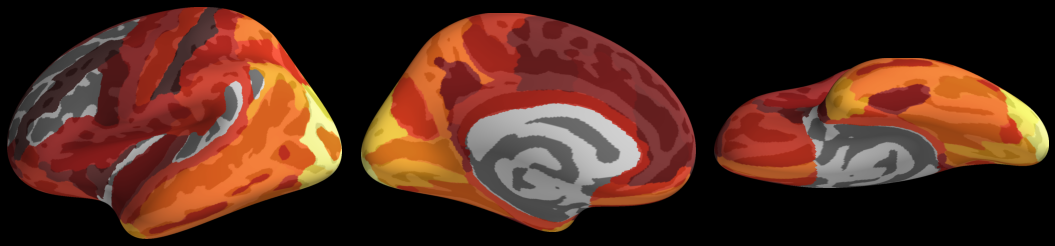

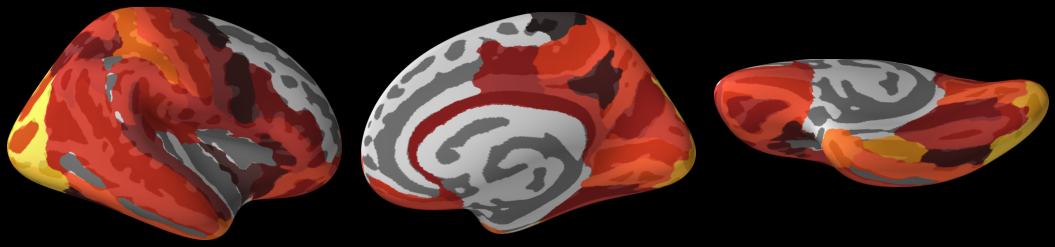

In [34]:
out_base = os.path.join(out_dir, "herit_holzinger")

vals = herit_holzinger
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

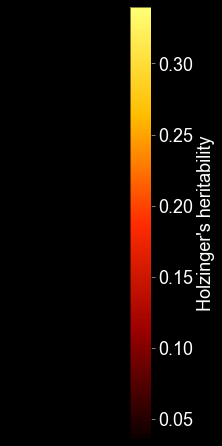

In [35]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Holzinger's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Holzinger's heritability in subcortex

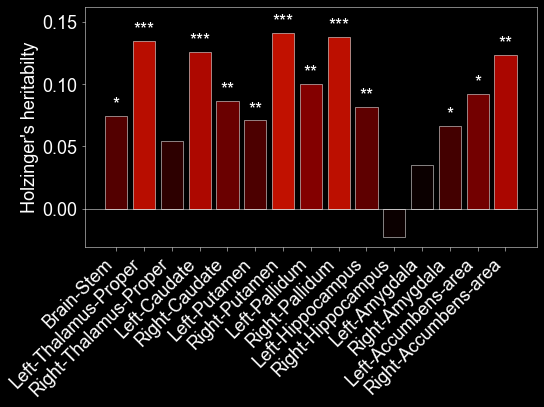

In [36]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = herit_holzinger[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.005, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Holzinger's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "herit_holzinger_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Supplementary Fig. 2E–F: Heritability without noise-ceiling correction

### Generate tables

In [37]:
out_file = os.path.join(out_dir, "uncor_herit.csv")

stat = np.array([stats.wilcoxon(x, y) for x, y in zip(mz_sim, dz_sim)])
T_vals = stat[:, 0]
p_vals = stat[:, 1]
twin_sim_rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)
mask_gen_effect = np.logical_and(twin_sim_rejected, mz_sim.mean(axis=1) > dz_sim.mean(axis=1))

# Save the table to a excel file
cols = ["Region name", "Falconer's heritability", "Holzinger's heritability"]

d = np.zeros((n_rois, 2))
d[:, 0] = uncor_herit_falconer
d[:, 1] = uncor_herit_holzinger

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping of Falconer's heritability

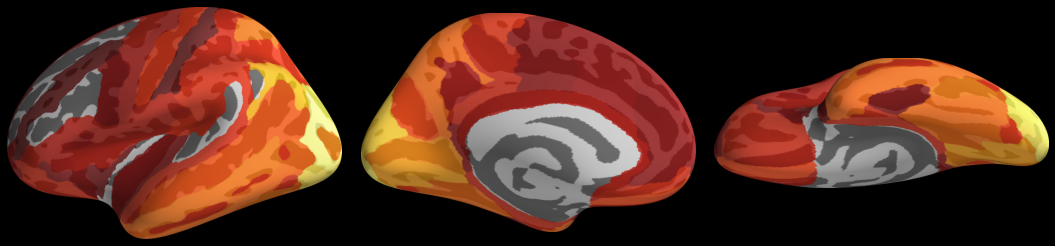

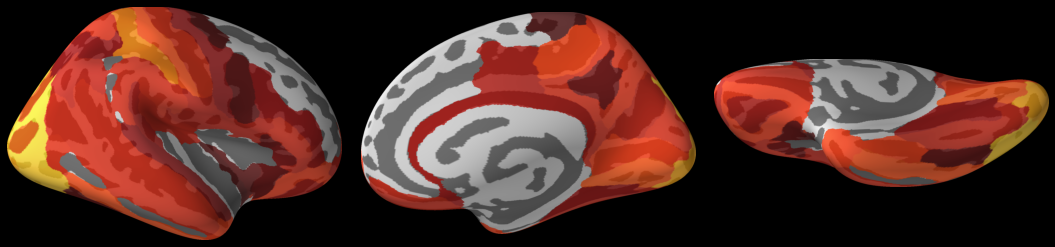

In [38]:
out_base = os.path.join(out_dir, "uncor_herit_falconer")

vals = uncor_herit_falconer
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = 0
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

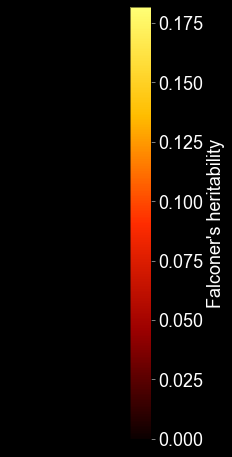

In [39]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Falconer's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Falconer's heritability in subcortex

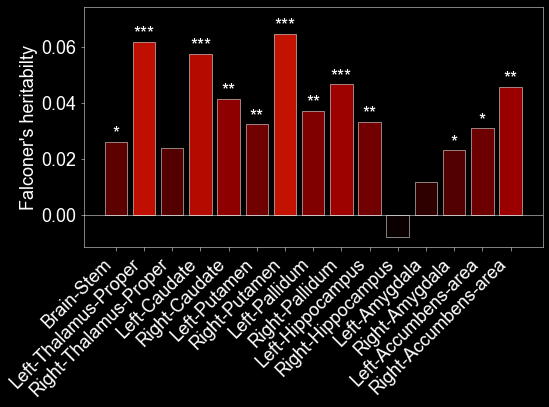

In [40]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = uncor_herit_falconer[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.001, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Falconer's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "uncor_herit_falconer_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Cortical mapping of Holzinger's heritability

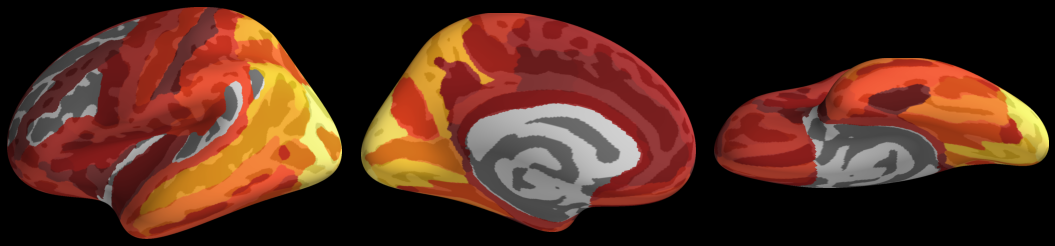

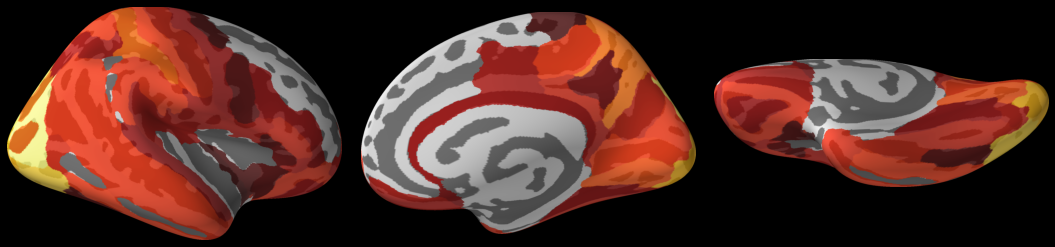

In [41]:
out_base = os.path.join(out_dir, "uncor_herit_holzinger")

vals = uncor_herit_holzinger
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = 0
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

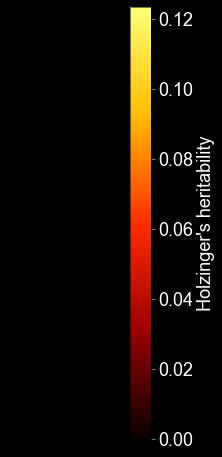

In [42]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Holzinger's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Holzinger's heritability in subcortex

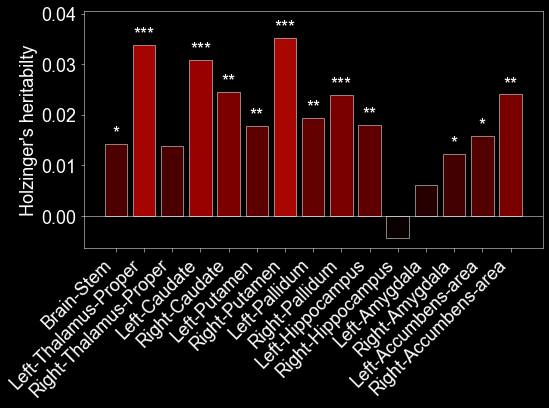

In [43]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = uncor_herit_holzinger[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.001, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Holzinger's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "uncor_herit_holzinger_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Supplementary Figs. 4: Heritability after noise-ceiling correction for ICC

### Generate tables

In [44]:
out_file = os.path.join(out_dir, "herit_icc.csv")

stat = np.array([stats.wilcoxon(x, y) for x, y in zip(icc_mz_sim, icc_dz_sim)])
T_vals = stat[:, 0]
p_vals = stat[:, 1]
twin_sim_rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)
mask_gen_effect = np.logical_and(twin_sim_rejected, icc_mz_sim.mean(axis=1) > icc_dz_sim.mean(axis=1))

# Save the table to a excel file
cols = ["Region name", "MZ-DZ difference T value", "MZ-DZ difference P value (FDR corrected)", "Falconer's heritability", "Holzinger's heritability"]

d = np.zeros((n_rois, 4))
d[:, 0] = T_vals
d[:, 1] = corr_p_vals
d[:, 2] = icc_herit_falconer
d[:, 3] = icc_herit_holzinger

df = pd.DataFrame(np.hstack([roi_names[:, np.newaxis], d]), columns=cols)
df.to_csv(out_file, index=False)

### Cortical mapping of Falconer's heritability

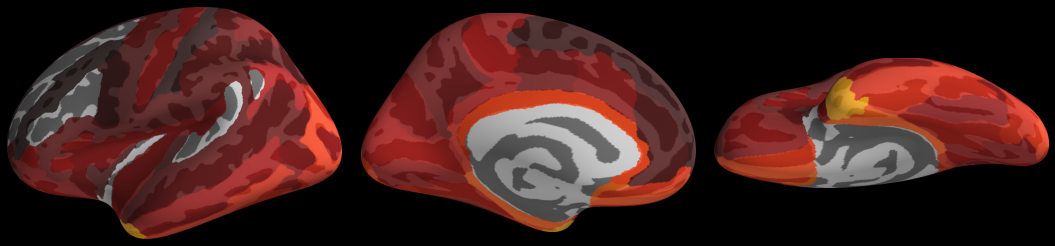

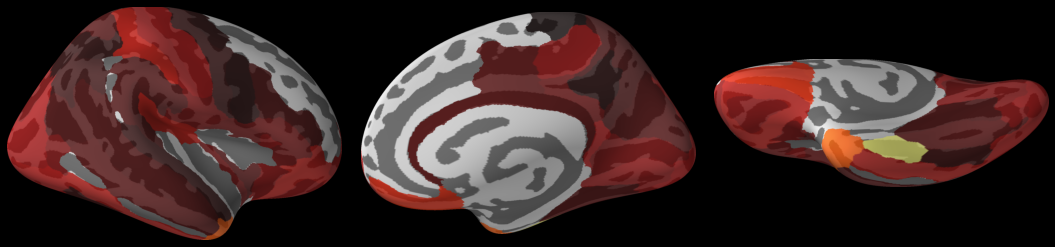

In [45]:
out_base = os.path.join(out_dir, "herit_icc_falconer")

vals = icc_herit_falconer
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

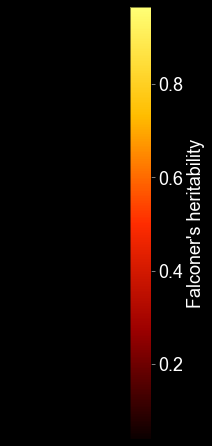

In [46]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Falconer's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Falconer's heritability in subcortex

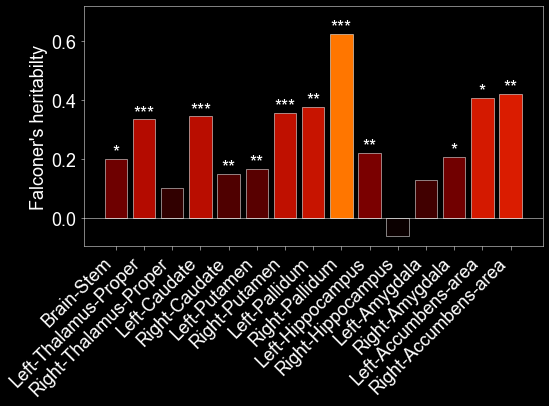

In [47]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = icc_herit_falconer[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.005, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Falconer's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "herit_icc_falconer_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

### Cortical mapping of Holzinger's heritability

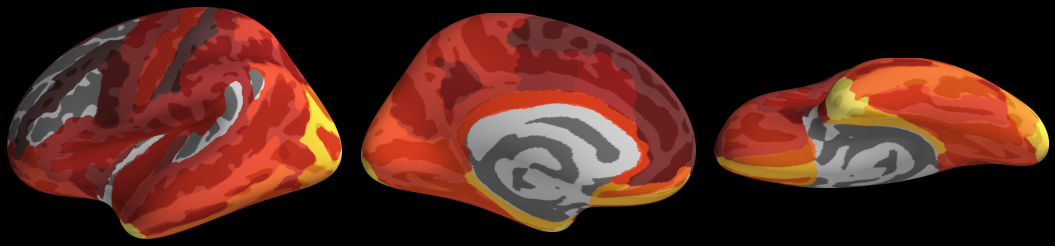

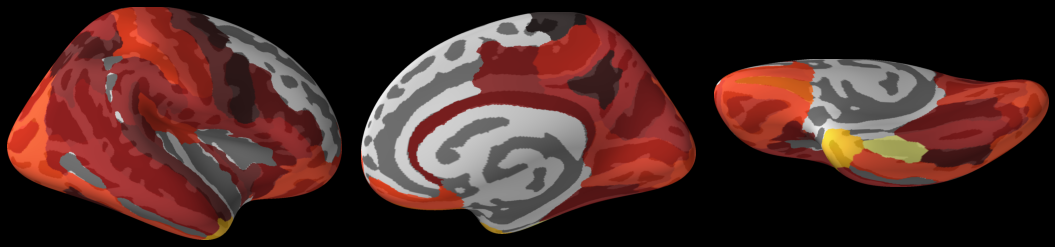

In [48]:
out_base = os.path.join(out_dir, "herit_icc_holzinger")

vals = icc_herit_holzinger
null_val = -2

# Get values for each ROI
hemi_vals = np.zeros((2, n_hemi_rois)) + null_val  # hemisphere x ROI
for i in range(2):
    mask = np.logical_and(roi_idx[i, :] != -1, mask_gen_effect[roi_idx[i, :]])
    hemi_vals[i, mask] = vals[roi_idx[i, mask]]

min_val = hemi_vals[hemi_vals != null_val].min()
max_val = hemi_vals[hemi_vals != null_val].max()
thresh_val = min_val
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

views = ["lat", "med", "ven"]

for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
    # Bring up the visualization.
    brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

    vtx_data = hemi_vals[i, labels]
    vtx_data[labels == -1] = null_val
    brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                   colorbar=False, smoothing_steps=None, verbose=0)

    ## Save views
    for view in views:
        brain.show_view(view)
        fname = "{}_{}_{}.png".format(out_base, hemi, view)
        brain.save_image(fname)
    
        ## Trim
        cmd = 'mogrify -trim ' + fname
        subprocess.call(cmd.split())
    
    ### Show images
    plt.figure(figsize=(15, 5), facecolor="k")
    
    for vi, view in enumerate(views):
        img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
        plt.subplot(1, 3, vi + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    brain.close()

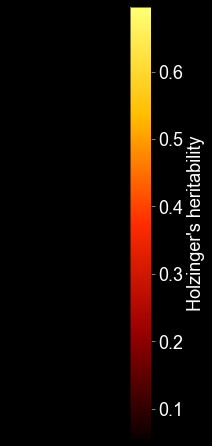

In [49]:
# Colorbar

out_name = out_base + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1/3, 1))

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Holzinger's heritability", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

plt.show()

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Holzinger's heritability in subcortex

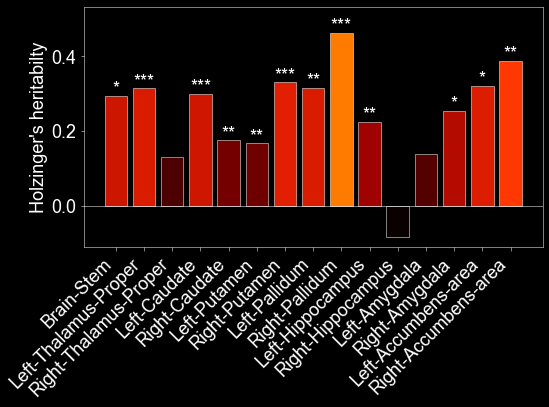

In [50]:
fig = plt.figure(figsize=(8, 6), facecolor="k")
ax = fig.add_subplot(111)

x = np.arange(n_subctxs)
y = icc_herit_holzinger[subctx_ids]
ps = corr_p_vals[subctx_ids]
for xx, yy, p in zip(x, y, ps):
    idx = int((yy - min_val) / (max_val - min_val) * 255)
    if idx < 0:
        idx = 0
    c = cm(idx)
    ax.bar(xx, yy, lw=.5, edgecolor="w", facecolor=c)
    
    if p < 0.00001:
        mk = "***"
    elif p < 0.001:
        mk = "**"
    elif p < 0.05:
        mk = "*"
    else:
        mk = ""
    ax.text(xx, yy + 0.005, mk, color="w", ha="center")

ax.set_facecolor("k")
ax.spines["bottom"].set_color("w")
ax.spines["top"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["right"].set_color("w")

ax.set_xticks(x)
ax.set_xticklabels(roi_names[subctx_ids], color="w", rotation=45, ha="right")
ax.set_ylabel("Holzinger's heritabilty", color="w")
ax.set_ylim([ax.get_ylim()[0], y.max() * 1.15])
ax.tick_params(colors="w")

ax.axhline(0, color="w")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "herit_icc_holzinger_subctx.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="k")
pp.close()

## Supplementary Fig. 5: Correlation between heritability and noise ceiling

In [51]:
mean_noise_ceiling = noise_ceiling.mean(axis=1)
p_vals = np.array([stats.wilcoxon(x, y)[1] for x, y in zip(mz_sim, dz_sim)])
twin_sim_rejected, corr_p_vals = fdrcorrection(p_vals, alpha=0.05)
mask_gen_effect = np.logical_and(twin_sim_rejected, mz_sim.mean(axis=1) > dz_sim.mean(axis=1))

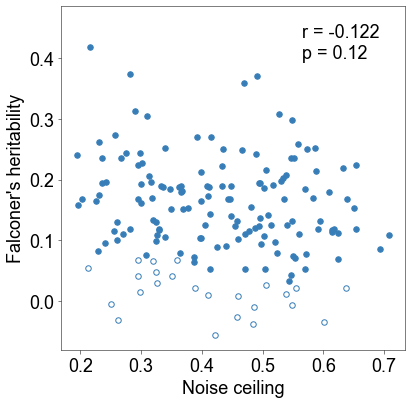

In [52]:
fig = plt.figure(figsize=[6, 6])

col = mpl.cm.Set1(1)

# Falconer's heritability
ax = plt.subplot(1, 1, 1)

x = mean_noise_ceiling[mask_gen_effect == False]
y = herit_falconer[mask_gen_effect == False]
ax.scatter(x, y, marker="o", s=30, c="w", edgecolors=col)

x = mean_noise_ceiling[mask_gen_effect]
y = herit_falconer[mask_gen_effect]
ax.scatter(x, y, marker="o", s=30, c=[col])

r, p = stats.pearsonr(mean_noise_ceiling, herit_falconer)
ax.text(0.7, 0.85, f"r = {r:.3g}\np = {p:.3g}", transform=ax.transAxes)

ax.axis("square")

ax.set_xlabel("Noise ceiling")
ax.set_ylabel("Falconer's heritability")

fig.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "corr_noise_herit.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight")
pp.close()